In [1]:
import numpy as np
import random
import os
import cv2
from matplotlib import pyplot as plt
from numba import jit,cuda
import tensorflow as tf
from time import time
import pickle as pkl
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from skimage.io import imsave


In [2]:
"""
%%cmd
pip install wandb
pip install scikit-image
pip install skimage
pip install numba
pip install keras-unet

"""

'\n%%cmd\npip install wandb\npip install scikit-image\npip install skimage\npip install numba\npip install keras-unet\n\n'

In [3]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [4]:
train_images_list =os.listdir("data/train/")
test_images_list = os.listdir("data/test/")

random.shuffle(train_images_list)
random.shuffle(test_images_list)

random.shuffle(train_images_list)
random.shuffle(test_images_list)

random.shuffle(train_images_list)
random.shuffle(test_images_list)

In [5]:
trainImageColorful = list(map(lambda x : "data/train/"+x ,train_images_list[0:10000]))
testImageColorful = list(map(lambda x : "data/test/"+x ,test_images_list[0:1000]))


In [6]:
len(trainImageColorful)

10000

In [7]:
def preprocess_image_to_gray_lab(img):
    img = cv2.resize(cv2.imread(img),(400,400))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = img_to_array(load_img(img))
    img = rgb2lab(img/255)
    img = img[:,:,0]
    img = img.reshape(400, 400, 1)
    
    return img

def preprocess_image_to_lab(img):
    img = cv2.resize(cv2.imread(img),(400,400))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = img_to_array(load_img(img))
    img = rgb2lab(img/255)
    img = img[:,:,1:]
    img /= 128
    img = img.reshape(400, 400, 2)

    return img



In [8]:
trainImageColorful[0]

'data/train/insta10498.jpg'

In [9]:

def train_data_generator(trainImageColorful,num_photos_per_batch):
    
    X, y = [], []

    n = 0

    while True:

        for key in trainImageColorful:
            n +=1

         

          
          
                
            X.append(preprocess_image_to_gray_lab(key))
                   
            y.append(preprocess_image_to_lab(key))
         

            if n==num_photos_per_batch:
                u = np.array(X)
                w = np.array(y)
            
             
               
                yield(u,w)
                
                X,  y = [], []
                n = 0
def valid_data_generator(validImageColorful,num_photos_per_batch):
    
    X, y = [], []

    n = 0

    while True:

        for key in validImageColorful:
            n +=1

      
          
          
                
            X.append(preprocess_image_to_gray_lab(key))
                   
            y.append(preprocess_image_to_lab(key))
         

            if n==num_photos_per_batch:
                u = np.array(X)
                w = np.array(y)
            
             
               
                yield(u,w)
                
                X,  y = [], []
                n = 0
 

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
#import wandb 
#wandb.init()

In [23]:
model = Sequential()
model.add(InputLayer(input_shape=(400, 400, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same' , strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same' , strides=2))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same' ))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [25]:
from tensorflow.keras.optimizers import Adam

model.compile("rmsprop",loss='mse' ,metrics=["accuracy"])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 200, 200, 32)      320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 200, 32)      9248      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 200, 200, 64)      18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 128)      

In [14]:
epochs = 100
number_pics_per_bath = 10
train_steps = len(trainImageColorful)//number_pics_per_bath
valid_steps = len(testImageColorful)//number_pics_per_bath

In [27]:
from keras.models import Model,load_model
model = load_model("model_weights\saved-model-02-0.65.hdf5")

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
filepath = "model_weights/saved-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [28]:
train_generator = train_data_generator(trainImageColorful=trainImageColorful,num_photos_per_batch=number_pics_per_bath)
valid_generator = valid_data_generator(validImageColorful=testImageColorful,num_photos_per_batch=number_pics_per_bath)
 
model.fit(train_generator,epochs=epochs,steps_per_epoch=train_steps,validation_data=(valid_generator),validation_steps=valid_steps,workers=-1,verbose=1,callbacks=[es,checkpoint])
       

Epoch 1/100
 760/1000 [=====================>........] - ETA: 8:51 - loss: 0.0094 - accuracy: 0.6528

In [21]:
def show_images(i,coloring):
    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
  
    normal = load_img(i,color_mode="grayscale",target_size=(400,400))
    plt.imshow(normal, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title("Gray image")
    

    fig.add_subplot(rows, columns, 2)
    
  
    plt.imshow(coloring)
    plt.axis('off')
    plt.title("AI Colorizing")

def mergeOutput(x,output):
    output *= 128
  
    cur = np.zeros((400, 400, 3))
    cur[:,:,0] = x[0][:,:,0]
    cur[:,:,1:] = output[0]
    return cur

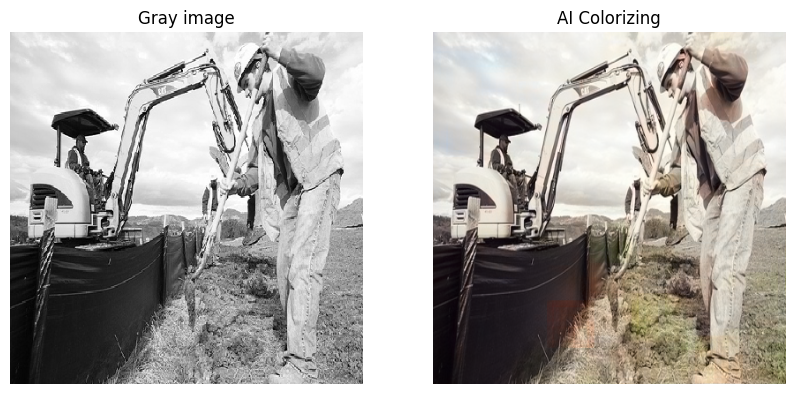

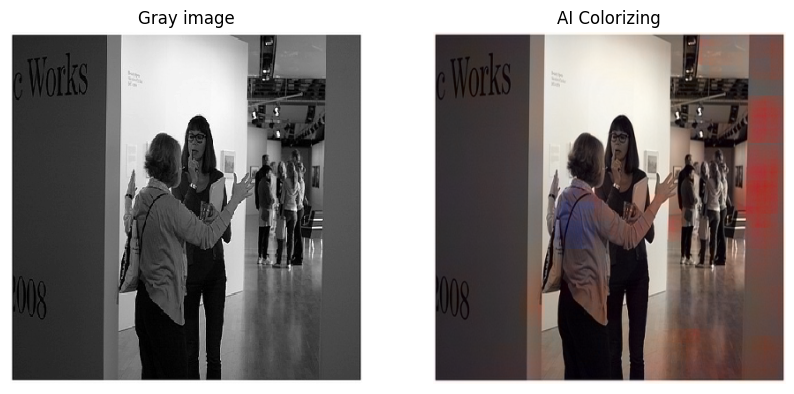

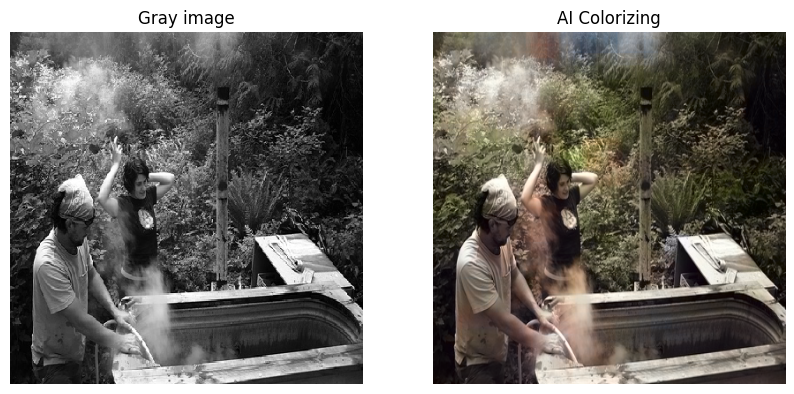

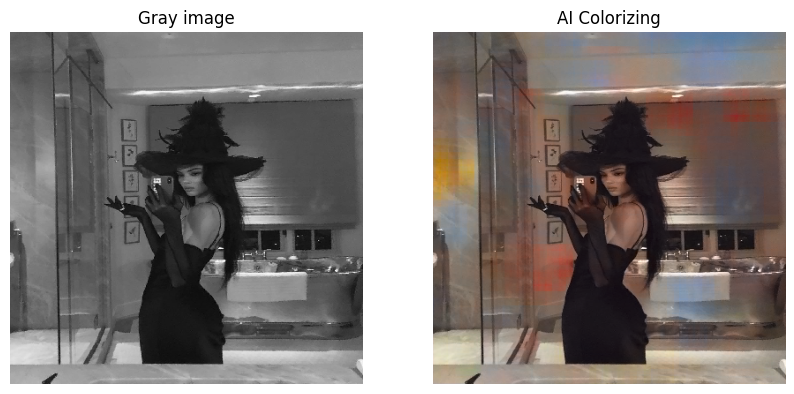

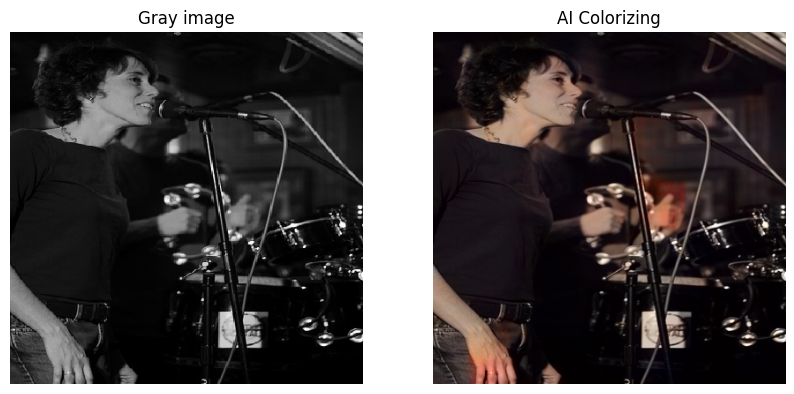

In [22]:
for i in testImageColorful[0:5]:
    
    x = preprocess_image_to_gray_lab(i)
    
    x = x.reshape(1,400,400,1)

    output = model.predict(x)
    
    cur = mergeOutput(x,output)
    
    img = lab2rgb(cur)

   
    show_images(i,img)

   
 

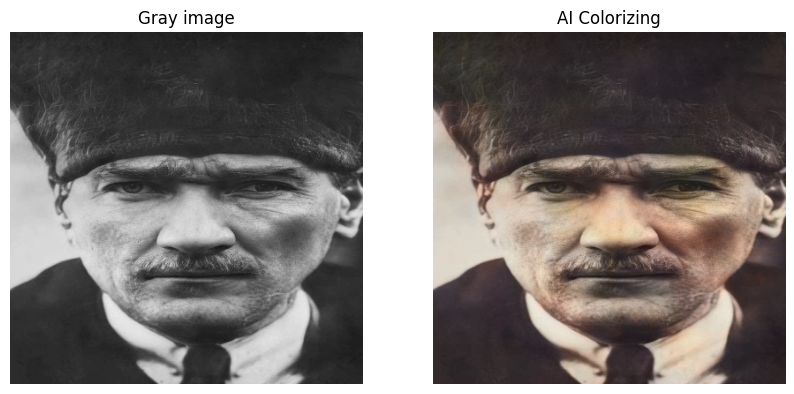

In [20]:
x = preprocess_image_to_gray_lab("test images/ataturk3.jpg")

x = x.reshape(1,400,400,1)

output = model.predict(x)
    
cur = mergeOutput(x,output)
    
img = lab2rgb(cur)

   
show_images("test images/ataturk3.jpg",img)
